## Regression methods for data modeling

As discussed in week one of this course, we will be investigating how to build a statistical regression model using data.

Regression modeling plays a major role in data analysis and builds upon fundamental concepts of statistics. By fitting models to data we are able to accomplish the following:

- **Estimate** distributional properties of variables, potentially conditional on other variables.

- Concisely **summarize relationships** between variables, and make inferential statements about those relationships.

- **Predict** values of variables of interest conditional on values of other _predictor_ variables, and characterize prediction uncertainty.

With these concepts in mind, in this notebook we illustrate some basic techniques for regression modeling by analyzing a dataset that contains information about people with diabetes.


#### Import libraries and read data

To begin, let's import our libraries and read the dataset from the filesystem.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_diabetes
import statsmodels.api as sm

dm_dataset = load_diabetes()
dm = pd.DataFrame(data=dm_dataset.data, columns=dm_dataset.feature_names)

#### Investigate the dataset structure

Now that we have loaded our dataset, let's get a feel for what the data look like:


In [2]:
dm.shape

(442, 10)

Based on the above output, we have 442 observations and 10 columns. To get a better sense of the data, let's print the column names:


In [3]:
dm.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

The meaning of each variable is discussed at the link below:

https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

Here's a view of the first five rows of our dataframe:


In [4]:
dm.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


#### Handle Missing Data

Before we get started and discuss how to approach building a model, it's good practice to assess the prevalence of missing values and handle them accordingly:


In [5]:
dm.isnull().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

Fortunately, our output indicates that none of our columns contain missing values.


#### Formulating a regression analysis

Most methods of regression analysis aim to explain the variation in a specific variable called the _dependent variable_ in terms of other variables called _independent variables_. Terminology is diverse in this area, and the dependent variable may also be referred to as the _outcome_ or the _response_, while the independent variables may also be referred to as _regressors_, _predictors_, _explanatory variables_, or _covariates_.

There are no strict rules governing which variables may serve as the independent or dependent variables in a regression model. In general the dependent variable will be something that is useful to predict in practice (perhaps because it is hard to measure directly), or that we view as being causally influenced by at least some of the independent variables. The issue of causality in regresion analysis is extremely important but subtle, and is not something that we will consider deeply here.

For the diabetes data, we will use _s6_ (glucose level) as the dependent variable. The other variables include demographic variables (age, sex), clinical variables (BMI, blood pressure), and other blood chemistry variables (e.g. triglycerides). Thus, we aim to explain the variation in blood glucose levels in terms of a person's demographic, clinical, and blood chemistry status.


#### Exploratoring marginal relationships

Most applications of regression analysis involve multiple explanatory variables. The explanatory variables may be associated with each other, as well as being associated with the outcome. Before proceeding with a multiple regression analysis, it is of interest to consider the "marginal" association of each independent variable with the response. One way to do this is to calculate the correlation coefficient between each predictor variable and the outcome. Correlation coefficients range from -1 to 1, conveying the strength of the relationship between two variables. Correlation values close to 1 signify a strong positive relationship, meaning that greater values of one variable tend to co-occur with greater values of the other vairable. A correlation value close to -1 indicates a strong negative relationship, in which greater values of one variable tend to co-occur with lesser values of the other variable. Correlation coefficients are powerful descriptive statistics, but have limitations. They are most effective at summarizing monotone relationships, especially when the relationship is approximately linear.

We can compute the correlation coefficient between every pair of variables among both the independent and dependent variables. The result of doing this is the _correlation matrix_. The table below allows us to visualize the correlation matrix as a heatmap. Note that the diagonal of any correlation matrix is identically equal to 1, so we do not include that in the heatmap.


c:\Users\dongh\anaconda3\envs\py3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

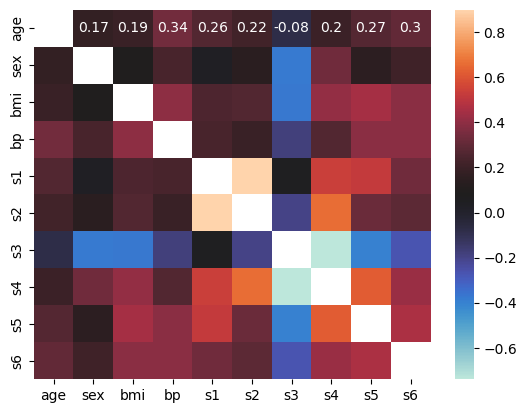

In [6]:
correlation_matrix = dm.corr().round(2)
correlation_matrix *= 1 + np.diag(np.nan * np.ones(10))
sns.heatmap(data=correlation_matrix, annot=True, cmap="icefire")

From the heatmap of the correlation matrix, we can see that there are substantial correlations between the dependent variable (s6) and each of the independent variables. These correlations are positive with the exception of s3 (hdl). It is also evident that the explanatory variables are correlated with each other, sometimes strongly (e.g. the correlation between s1 and s2 is 0.9).


A correlation coefficient summarizes the relationship between two variables in terms of one number. In some cases we can learn much more about the relationship between two variables by viewing a scatterplot. A _scatterplot matrix_ connstructs the scatterplot for every pair of variables. For simplicity, here we will focus only on the relationships between each independent variable and the dependent variable. To further enhance the visualization, we plot an estimate of the _conditional mean function_ obtained using the _lowess_ procedure (this is the red curve in the plots below). The conditional mean function is essentially a smooth curve running through the points in the scatterplot.


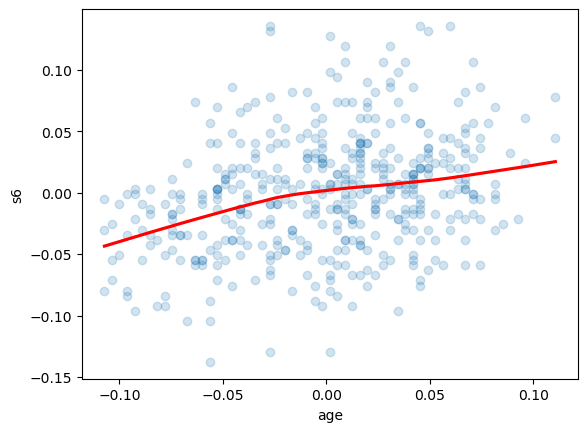

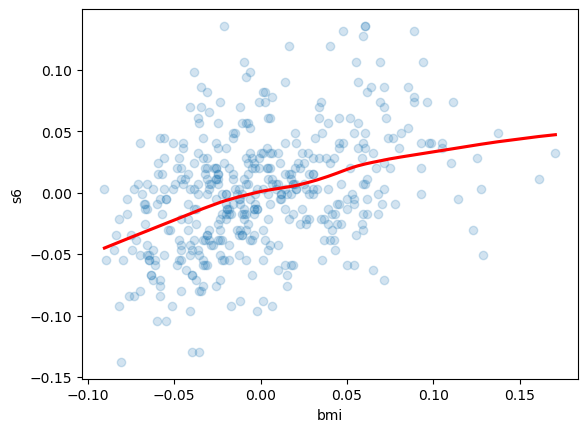

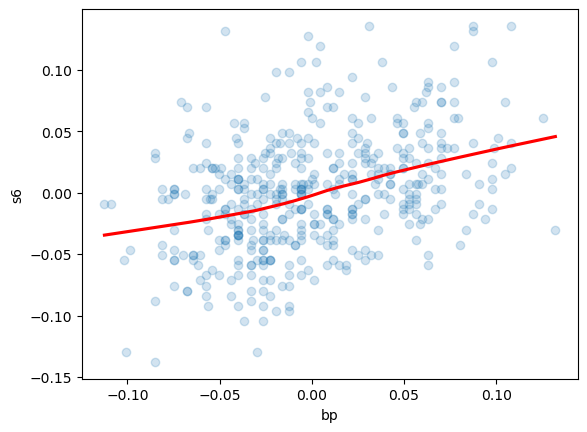

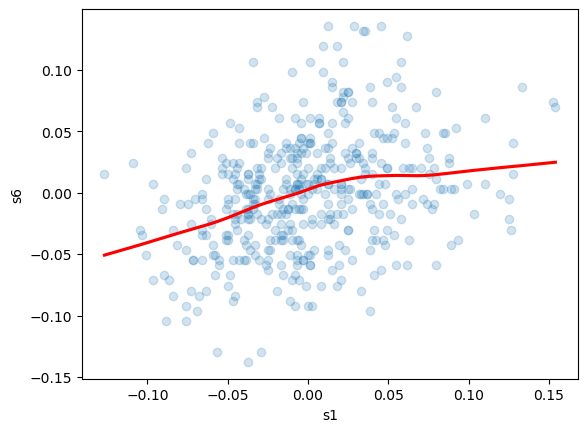

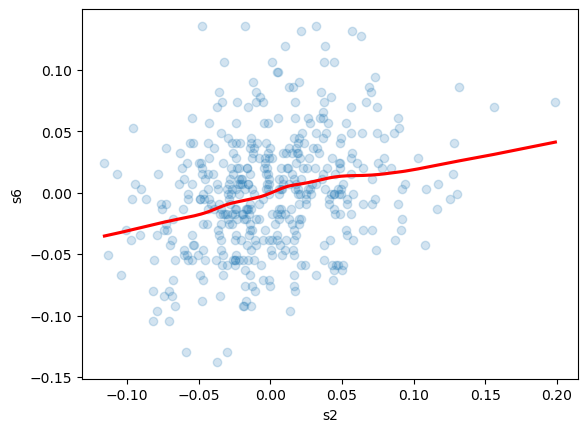

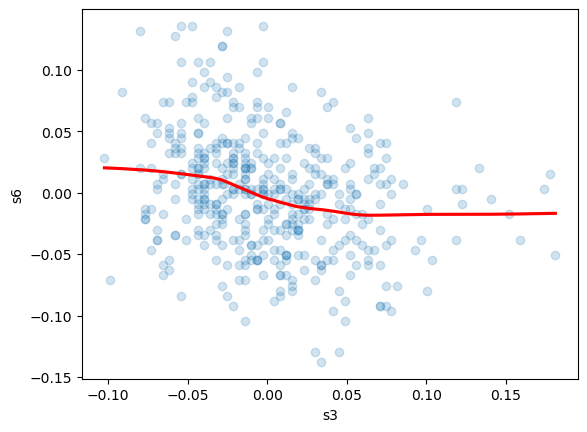

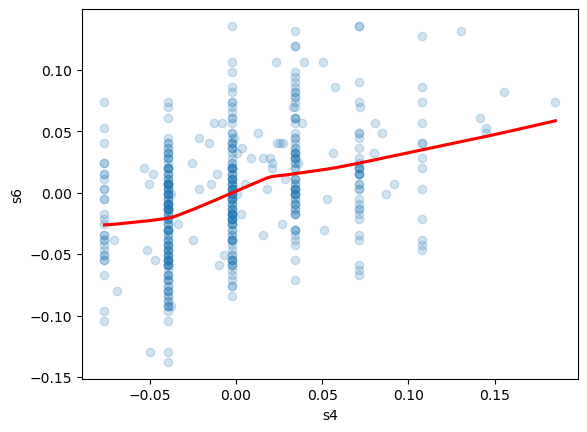

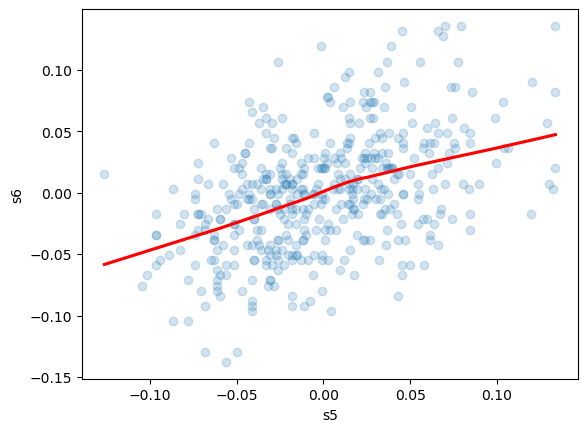

In [7]:
for v in dm.columns:
    if v in ["s6", "sex"]:
        continue
    plt.figure()
    sns.regplot(
        x=v,
        y="s6",
        data=dm,
        lowess=True,
        scatter_kws={"alpha": 0.2},
        line_kws={"color": "red"},
    )

From the scatterplots above, we see that each explanatory variable has a _monotone_ relationship with the outcome variable, in the sense that the conditional mean function is a monotone (non-decreasing or non-increasing) function of the explanatory variable.
Some of these relationships are approximately linear, while others have different shapes, for example, the conditional mean function for s6 in terms of s3 reaches a plateau.

For large datasets, scatterplots are not very informative due to _overplotting_. This is not such an issue here, but to illustrate how to address overplotting we show below how to visualize the joint distribution between each explanatory variable and the response variable using two-dimensional density estimates.


c:\Users\dongh\anaconda3\envs\py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dongh\anaconda3\envs\py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dongh\anaconda3\envs\py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dongh\anaconda3\envs\py3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

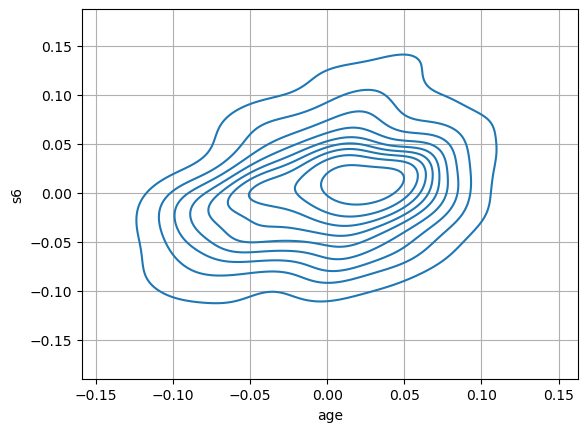

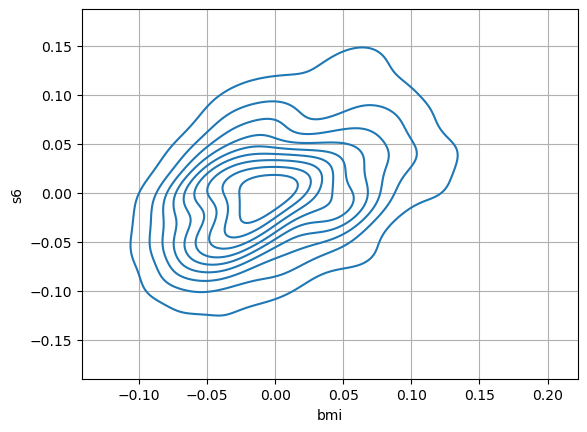

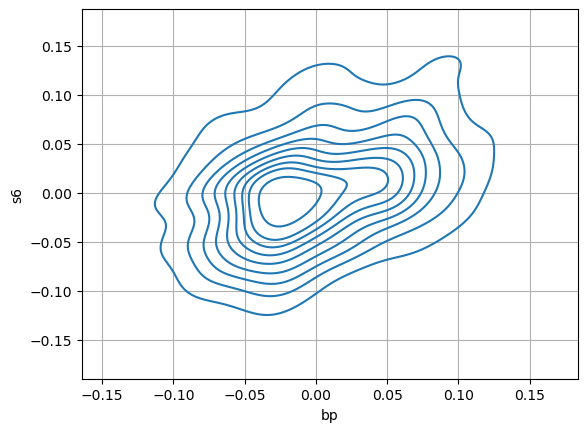

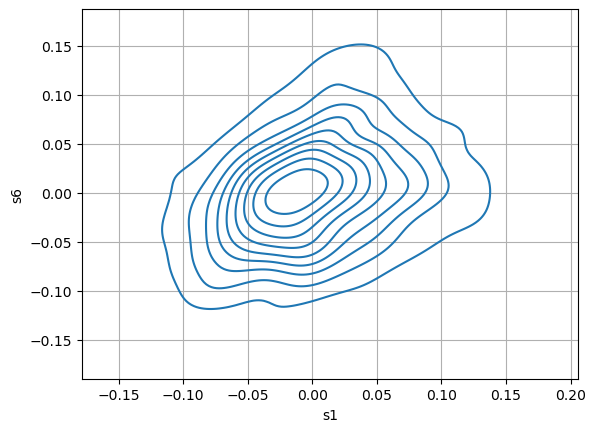

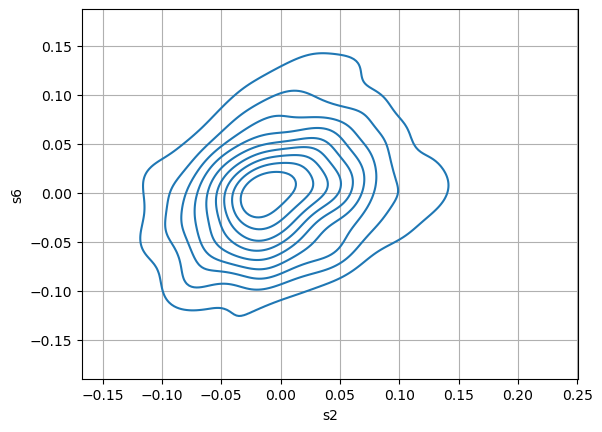

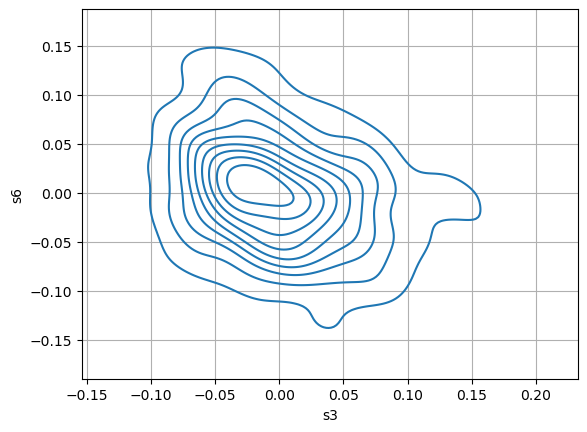

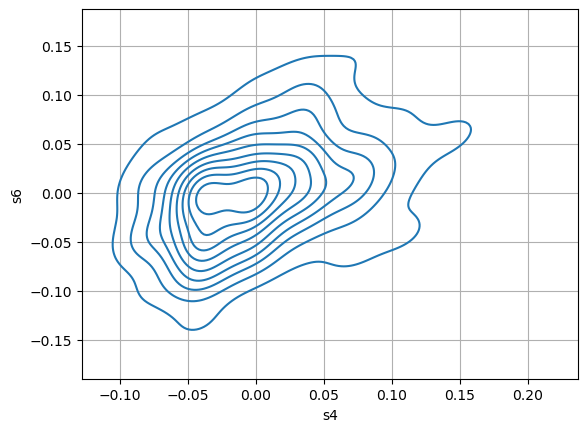

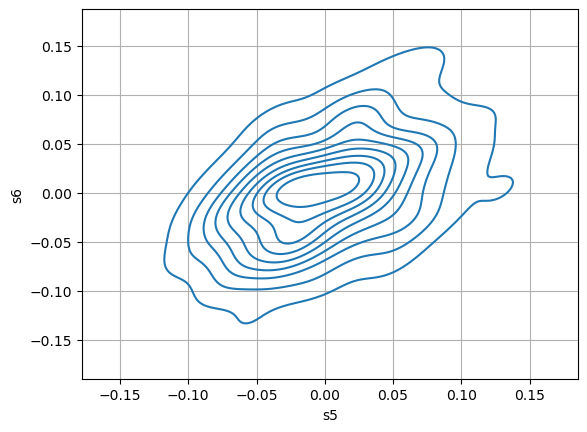

In [9]:
# dm.replace(np.inf, np.nan)
for v in dm.columns:

    if v in ["s6", "sex"]:

        continue

    plt.figure()

    plt.grid(True)

    sns.kdeplot(x=v, y="s6", data=dm)

#### Fitting a linear model

Next we will fit a linear regression model to the diabetes data using a technique known as _ordinary least squares_ (OLS). In this notebook we are only aiming to introduce the process of regression analysis, and will not discuss the model in detail.

In brief, a linear model expresses the conditional mean of the dependent variable as a linear function of the independent variables. It does this by estimating _coefficients_ or _slopes_ for each independent variable, along with one additional coefficient known as the _intercept_. Below we fit a linear model of the form

$$
E[\textrm{s6} | \textrm{age}, \textrm{sex}, \textrm{bmi}, \textrm{bp}] = a_0 + a_1\textrm{age} + a_2\textrm{sex}+ a_3\textrm{bmi} + a_4\textrm{bp}
$$

The coefficients are $a_0$ (the intercept), $a_1$, $a_2$, $a_3$, and $a_4$. These coefficients are estimated or fit using the diabetes dataset. Below we fit the model:


In [10]:
m0 = sm.OLS.from_formula("s6 ~ age + sex + bmi + bp", dm)
r0 = m0.fit()
r0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     s6   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     37.54
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           5.35e-27
Time:                        16:50:26   Log-Likelihood:                 784.28
No. Observations:                 442   AIC:                            -1559.
Df Residuals:                     437   BIC:                            -1538.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.171e-17      0.002   5.97e-15      1.000      -0.004       0.004
age            0.1654      0.044      3.749      0.000       0.079       0.252
sex            0.1068      0.043      2.498      0.013       0.023       0.191
bmi            0.2683      0.045      5.961      0.000       0.180       0.357
bp             0.2031      0.048      4.248      0.000       0.109       0.297
==============================================================================
Omnibus:                        5.285   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.091
Skew:                           0.255   Prob(JB):                       0.0784
Kurtosis:                       3.124   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In a linear model, we can interpret each coefficient as the expected change of the dependent variable for each unit change in an independent variable, while holding the other independent variables fixed. For example, the estimated coefficient for age is $a_1=0.1654$. This indicates that if we compare two people of the same sex, BMI, and blood pressure, and one of these people is one year older than the other, then the blood glucose of the older person will on average be 0.1654 units greater than the blood glucose of the younger person.

A key aspect of multiple regression analysis is that the association attributed to each explanatory variable corresponds to a setting where the other explanatory variables are held fixed. This is in contrast to the correlation analysis conducted above, where each explanatory variable is considered in relation to the outcome variable, ignoring the roles of other variables. In some cases, an explanatory variable can have a strong _marginal_ association with the response variable when assessed using correlation, but has little to no association with the response in a multiple regression. In the present setting this does not seem to be the case, since age, sex, BMI, and blood pressure all have strong associations with blood glucose based on correlation coefficients as well as in the multiple regression analysis.
